In [2]:
%load_ext cython

import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import yaml
import io
from os import listdir
from os.path import isfile, join

sys.path.append("../src/")
from sarra_py import *

In [3]:
date_start = datetime.date(2022,1,1)
duration = 180

# parameter file names
file_paramVariete = "USA_iowa_V42.yaml"
file_paramITK = "USA_iowa_V42.yaml"
file_paramTypeSol = "USA_iowa_V42.yaml"

# data exported from SARRA-H
file_df_weather = "Meteorologie_US0001.txt"
file_df_rain = "Pluviometrie_US0001.txt"
file_df_ET0 = "ET0_US0001.txt"
file_df_irrig = "Irrigation_AG3US20124.txt"

# Loading TAMSAT rainfall data

In [4]:
# loading TAMSAT rainfall data
TAMSAT_path = "/mnt/d/Mes Donnees/SARRA_data-download/data/3_output/TAMSAT_v3.1_burkina_rfe_filled"
TAMSAT_files = [f for f in listdir(TAMSAT_path) if isfile(join(TAMSAT_path, f))]

TAMSAT_files_df = pd.DataFrame({"filename":TAMSAT_files})

TAMSAT_files_df["date"] = TAMSAT_files_df.apply(
    lambda x: datetime.date(
        int(x["filename"].replace(".tif","").split("_")[-3]),
        int(x["filename"].replace(".tif","").split("_")[-2]),
        int(x["filename"].replace(".tif","").split("_")[-1]),
    ),
    axis=1,
)

TAMSAT_files_df = TAMSAT_files_df[(TAMSAT_files_df["date"]>=date_start) & (TAMSAT_files_df["date"]<date_start+datetime.timedelta(days=duration))]
TAMSAT_files_df

,filename,date
0,TAMSAT_v3.1_burkina_rfe_filled_2022_01_01.tif,2022-01-01
1,TAMSAT_v3.1_burkina_rfe_filled_2022_01_02.tif,2022-01-02
2,TAMSAT_v3.1_burkina_rfe_filled_2022_01_03.tif,2022-01-03
3,TAMSAT_v3.1_burkina_rfe_filled_2022_01_04.tif,2022-01-04
4,TAMSAT_v3.1_burkina_rfe_filled_2022_01_05.tif,2022-01-05
...,...,...
175,TAMSAT_v3.1_burkina_rfe_filled_2022_06_25.tif,2022-06-25
176,TAMSAT_v3.1_burkina_rfe_filled_2022_06_26.tif,2022-06-26
177,TAMSAT_v3.1_burkina_rfe_filled_2022_06_27.tif,2022-06-27
178,TAMSAT_v3.1_burkina_rfe_filled_2022_06_28.tif,2022-06-28


In [5]:
import rasterio
src = rasterio.open(os.path.join(TAMSAT_path,TAMSAT_files_df.loc[0,"filename"]))
array = src.read(1)

# rainfall grid size defines output resolution
grid_width = array.shape[0]
grid_height = array.shape[1]

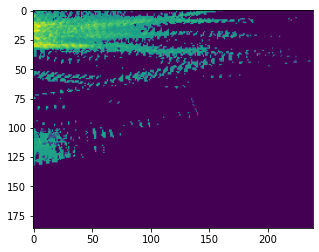

In [6]:
from matplotlib import pyplot
pyplot.imshow(array, cmap='viridis')

# Loading AgERA5 weather data

In [7]:
AgERA5_data_path = "/mnt/d/Mes Donnees/SARRA_data-download/data/3_output/AgERA5_burkina/"
AgERA5_variables = [path.split("/")[-1] for path in [x[0] for x in os.walk(AgERA5_data_path)][1:]]

# defining dict of dfs, one df per variable
AgERA5_files_df_collection = {}
for variable in AgERA5_variables:
    AgERA5_files = [f for f in listdir(os.path.join(AgERA5_data_path,variable)) if isfile(join(os.path.join(AgERA5_data_path,variable), f))]
    AgERA5_files_df_collection[variable] = pd.DataFrame({"filename":AgERA5_files})

    
    AgERA5_files_df_collection[variable]["date"] = AgERA5_files_df_collection[variable].apply(
        lambda x: datetime.date(
            int(x["filename"].replace(".tif","").split("_")[-3]),
            int(x["filename"].replace(".tif","").split("_")[-2]),
            int(x["filename"].replace(".tif","").split("_")[-1]),
        ),
        axis=1,
    )

    AgERA5_files_df_collection[variable] = AgERA5_files_df_collection[variable][(AgERA5_files_df_collection[variable]["date"]>=date_start) & (AgERA5_files_df_collection[variable]["date"]<date_start+datetime.timedelta(days=duration))]

# Feeding these datasets into the numpy matrices

In [8]:
import numpy as np

data = {}

# rain
data["rain"] = np.empty((grid_width, grid_height, duration))
for i in range(duration):
    dataset = rasterio.open(os.path.join(TAMSAT_path,TAMSAT_files_df.loc[i,"filename"]))
    data["rain"][:,:,i] = dataset.read(1)
    dataset.close()



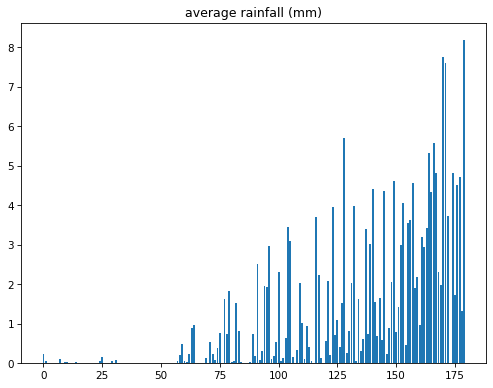

In [9]:
from matplotlib.pyplot import figure
# plotting rain for verif purpose
plot_value_mean = data["rain"].mean(axis=(0,1))
figure(figsize=(8, 6), dpi=75)
plt.bar(range(duration),plot_value_mean)
plt.title("average rainfall (mm)")
plt.show()

In [10]:
from rasterio.enums import Resampling

AgERA5_SARRA_correspondance = {
    '10m_wind_speed_24_hour_mean':None,
    '2m_temperature_24_hour_maximum':None,
    '2m_temperature_24_hour_mean':'tpMoy',
    '2m_temperature_24_hour_minimum':None,
    'ET0Hargeaves':'ET0',
    'solar_radiation_flux_daily':'rg',
    'vapour_pressure_24_hour_mean':None,
}

resampling_method = "nearest"

for variable in tqdm(AgERA5_variables) :
    if AgERA5_SARRA_correspondance[variable] != None :

        data[AgERA5_SARRA_correspondance[variable]] = np.empty((grid_width, grid_height, duration))

        for i in tqdm(range(duration), leave=False, desc="variable {variable}") :
            dataset = rasterio.open(os.path.join(AgERA5_data_path,variable,AgERA5_files_df_collection[variable].loc[i,"filename"]))

            arr = dataset.read(
                    out_shape=(
                        dataset.count,
                        grid_width,
                        grid_height,
                    ),
                    resampling=getattr(Resampling, resampling_method)
                )[0]

            data[AgERA5_SARRA_correspondance[variable]][:,:,i] = arr
            dataset.close()

# correcting rg
data["rg"] = data["rg"]/1000

# default irrigation scheme 
data["irrigation"] = np.empty((grid_width, grid_height, duration))

100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


In [11]:
data.keys()

dict_keys(['rain', 'tpMoy', 'ET0', 'rg', 'irrigation'])

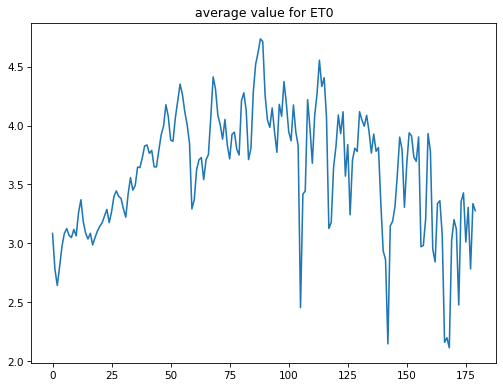

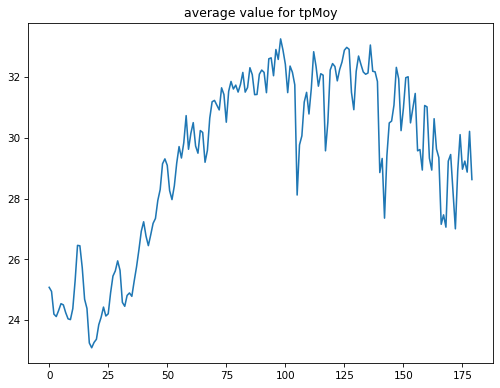

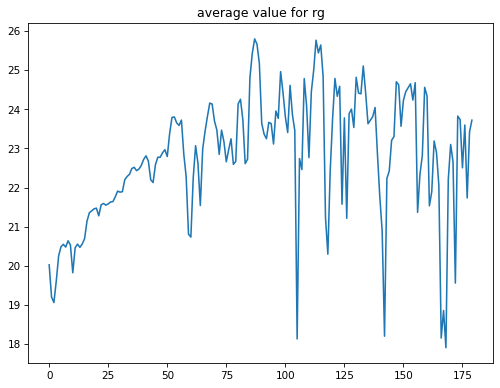

In [12]:
from matplotlib.pyplot import figure
for variable in ["ET0","tpMoy","rg"]:
    # plotting rain for verif purpose
    plot_value_mean = data[variable].mean(axis=(0,1))
    figure(figsize=(8, 6), dpi=75)
    plt.plot(plot_value_mean)
    plt.title("average value for "+variable)
    plt.show()

In [13]:
# https://towardsdatascience.com/read-era5-directly-into-memory-with-python-511a2740bba0

In [14]:
# Read YAML file
with open(os.path.join('../data/params/variety/',file_paramVariete), 'r') as stream:
    paramVariete = yaml.safe_load(stream)

if paramVariete["feuilAeroBase"] == 0.1 :
    raise exception()

with open(os.path.join('../data/params/itk/',file_paramITK), 'r') as stream:
    paramITK = yaml.safe_load(stream)

paramITK["DateSemis"] = datetime.datetime.strptime(paramITK["DateSemis"], "%Y-%m-%d").date()

with open(os.path.join('../data/params/soil/',file_paramTypeSol), 'r') as stream:
    paramTypeSol = yaml.safe_load(stream)

if ~np.isnan(paramITK["NI"]):
    print("NI NON NULL") 
    paramVariete["txConversion"] = paramVariete["NIYo"] + paramVariete["NIp"] * (1-np.exp(-paramVariete["NIp"] * paramITK["NI"])) - (np.exp(-0.5*((paramITK["NI"] - paramVariete["LGauss"])/paramVariete["AGauss"])* (paramITK["NI"]- paramVariete["LGauss"])/paramVariete["AGauss"]))/(paramVariete["AGauss"]*2.506628274631)

# alt : construction de grilles climatiques

# Run

In [15]:
def EvalPar(data):
    #depuis meteo.par
    kpar = 0.5
    data["par"] = kpar * data["rg"]
    return data

In [17]:
import warnings
warnings.filterwarnings("ignore")

# data = {}

data = InitPlotMc(data, grid_width, grid_height, paramITK, paramTypeSol, duration) # **** bileau *** # trad OK
data = InitiationCulture(data, grid_width, grid_height, duration, paramVariete)
data = InitSup(data, grid_width, grid_height, duration, paramTypeSol, paramITK)

# on débraye initsup2 car les données MTO sont chargées
# data = InitSup2(data, grid_width, grid_height, duration, df_weather)

# variables = {"tpMoy":"TEMP", "rain":"RAIN", "ET0":"ET0", "rg":"IRRAD"}
# for variable in variables:
#     print(variable)
#     data[variable] = np.empty((grid_width, grid_height, duration))
#     data[variable][:] = np.nan

#     for lon in range(grid_width):
#         for lat in range(grid_height):
#             try:
#                 data[variable][lat, lon, :] = weather_country.loc[(weather_country["LON"] == weather_country["LON"].unique()[lon]) & (weather_country["LAT"] == weather_country["LAT"].unique()[lat]), variables[variable]].values
#             except:
#                 pass


data = EvalPar(data)

for j in tqdm(range(duration)):
    # on reporte en commentaire les fichiers source dans lesquelles se trouvent
    # les procédures concernées. no note ***entre étoiles*** les procédures
    # retenues pour cette traduction python

    if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"]:

        data = EvalPhenoSarrahV3(j, data, paramITK, paramVariete) # ***phenologie*** et exmodules ### trad OK
        data = EvalDegresJourSarrahV3(j, data, paramVariete) # ***phenologie*** et exmodules ### trad OK

    # print(date_start + datetime.timedelta(days=j))
    #bilan hydrique
    data = EvalIrrigPhase(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = PluieIrrig(j, data) # ***bileau***, exmodules 2 ###trad OK
    data = RempliMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = EvalRunOff(j, data, paramTypeSol) # ***bileau***, exmodules 1 & 2 ###trad OK
    data = EvolRurCstr2(j, data, paramITK) # ***bileau*** ##trad OK
    data = rempliRes(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas ###trad OK
    data = EvalFESW(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad O
    data = EvalKceMc(j, data, paramITK) # ***bileau***, exmodules 2 ###trad OK
    data = DemandeSol(j, data) # ***bileau***, exmodules 1 & 2 ### trad OK
    data = EvapMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = EvapRuSurf(j, data) # ***bileau***, exmodules 1 & 2 ###trad OK
    data = EvalFTSW(j, data) # ***bileau***, exmodules 1 & 2, risocas, riz ###trad OK
    data = EvolKcpKcIni(j, data, paramVariete) # biomasse, exmodules 1 & 2 # comparaison  code nécessaire pour choix ###trad OK
    data = DemandePlante(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad OK
    data = EvalKcTot(j, data) # ***bileau***, exmodules 1 & 2 ## trad O
    data = CstrPFactor(j, data, paramVariete) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas #trad OK
    data = EvalTranspi(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 # trad OK
    data = ConsoResSep(j, data) # ***bileau***; exmodules 1 & 2 # trad O
    # phenologie
    data = EvalVitesseRacSarraV3(j, data, paramVariete) # ***phenologie*** , exmodules 1 & 2 # trad OK
    
    # bilan carbone
    data = EvalLtr(j, data, paramVariete) #biomasse, exmodules 1 & 2 # comparaison code nécessaire pour choix #trad OK
    data = EvalConversion(j, data, paramVariete) # mimlbilancarbone copie, ecopalm2_2, exmodules 1 & 2, ***milbilancarbone***, risocas, riz # trad OK
    data = BiomDensOptSarV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data = EvalAssimSarrahV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data = EvalRespMaintSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data = EvolBiomTotSarrahV4(j, data, paramVariete, paramITK) # ***bilancarbonsarra*** ### trad OK, vérifier questiond e la densité
    data = EvalRdtPotRespSarV42(j, data, paramVariete) # ***bilancarbonsarra*** ###trad OK
    data = EvolBiomAeroSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data = EvalReallocationSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data = EvalBiomasseRacinaire(j, data) # copie milbilancarbone, exmodules 1 & 2, ***milbilancarbone*** ### trad OK
    data = EvalFeuilleTigeSarrahV4(j, data, paramVariete) # ***bilancarbonesarra*** ### trad OK
    data = EvalBiomasseVegetati(j, data) # copie milbilancarbon, exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data = EvalSlaSarrahV3(j, data, paramVariete) # ***bilancarbonesarrah***, exmodules 1 & 2  ### trad OK
    data = EvolLAIPhases(j, data) # exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data = EvolDayRdtSarraV3(j, data) # ***bilancarbonesarra***, exmodules 1 & 2 ### trad OK
    #phenologie
    data = PhotoperSarrahV3(j, data, paramVariete) # exmodules 1 et 2, ***phenologie*** ###trad OK
    
    # bilan carbone
    data = MortaliteSarraV3(j, data, paramITK, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data = BiomDensiteSarraV42(j, data, paramITK, paramVariete)# ***bilancarbonsarra*** ### trad OK
    data = BiomMcUBTSV3(j, data, paramITK) # ***bilancarbonsarra***, exmodules 2
    data = MAJBiomMcSV3(data) # ***bilancarbonsarra***, exmodules 2


100%|██████████| 180/180 [06:25<00:00,  2.14s/it]


In [ ]:
for variable in data.keys() :
    plot_value_mean = data[variable].mean(axis=(0,1))
    plt.plot(plot_value_mean)
    plt.title(variable)
    plt.show()

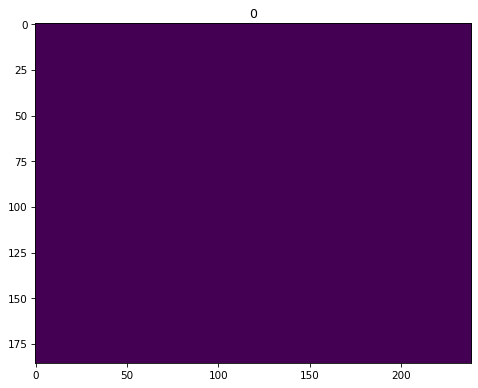

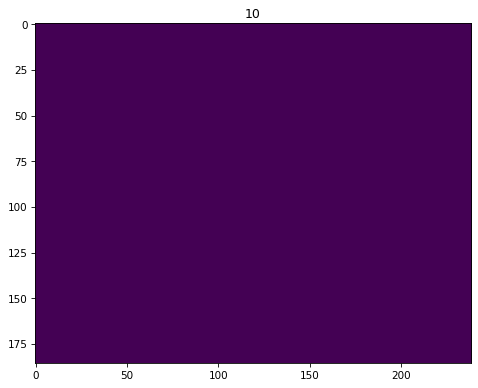

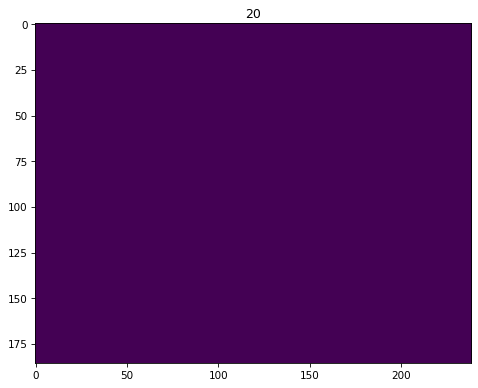

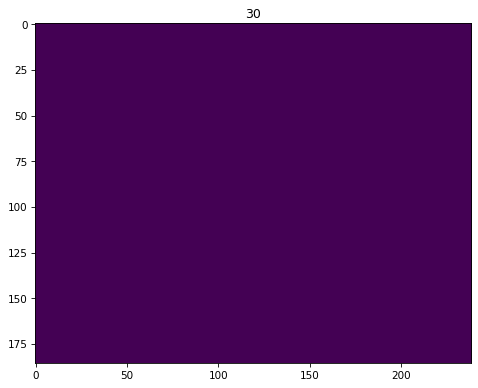

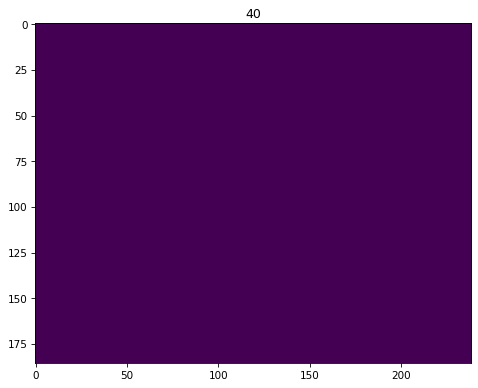

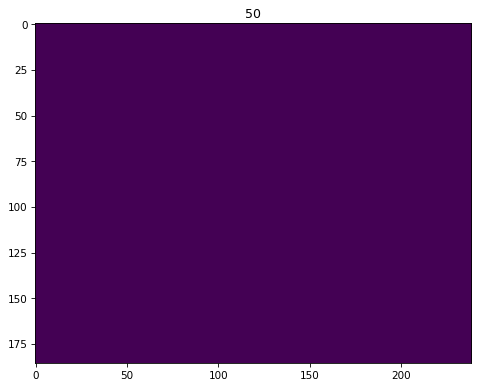

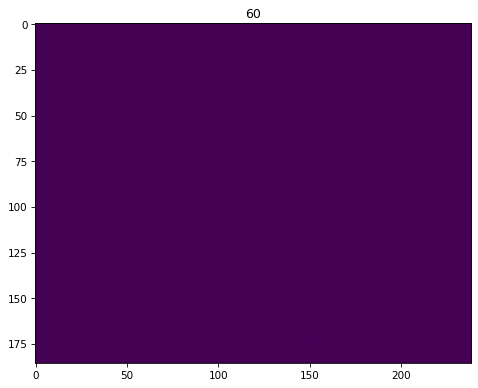

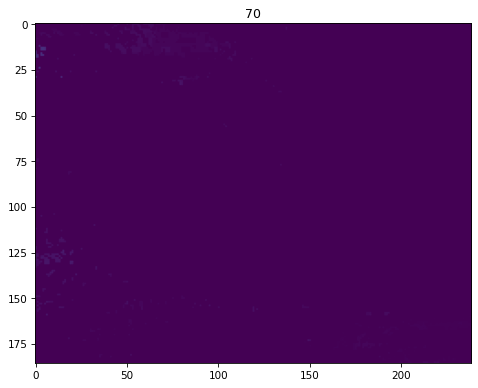

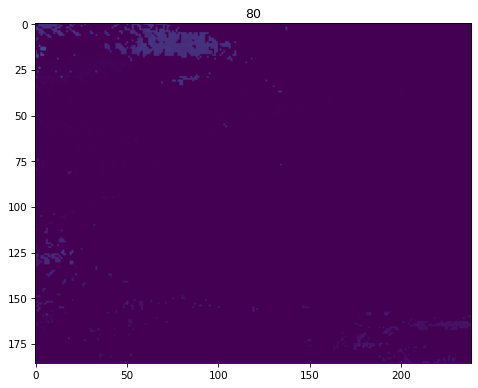

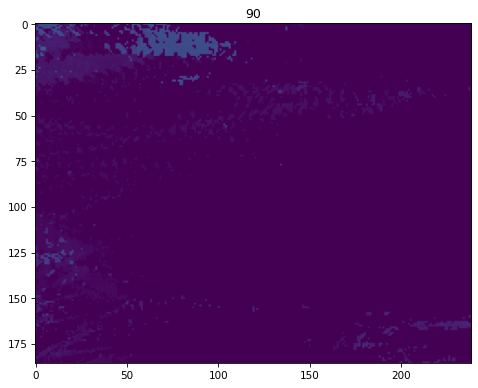

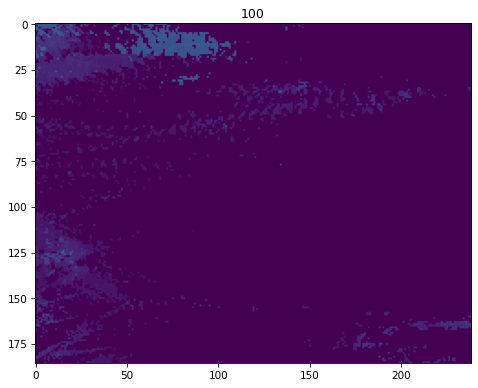

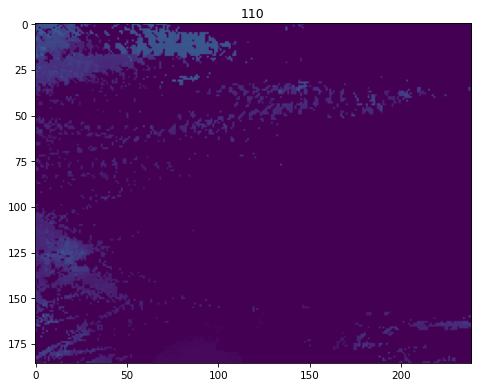

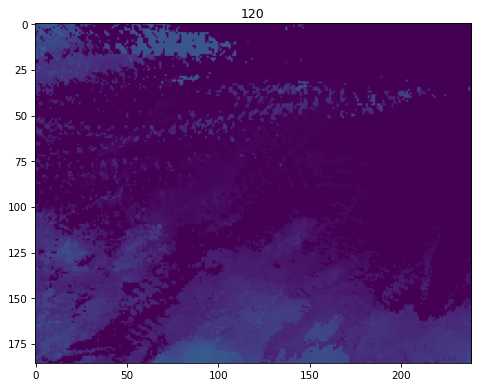

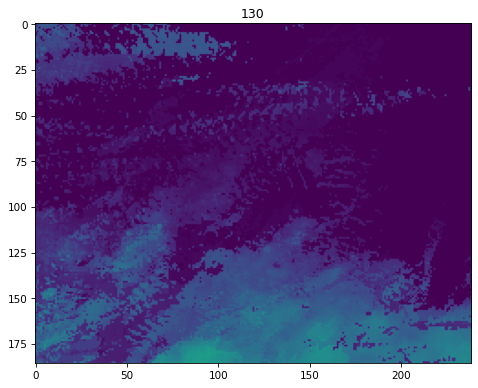

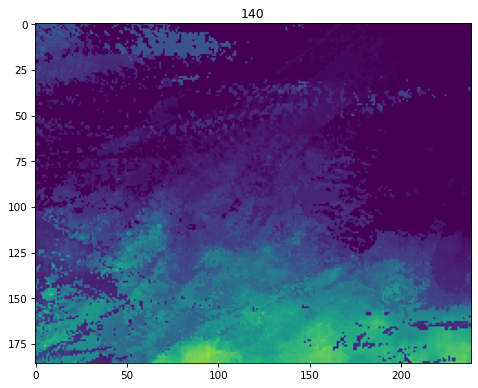

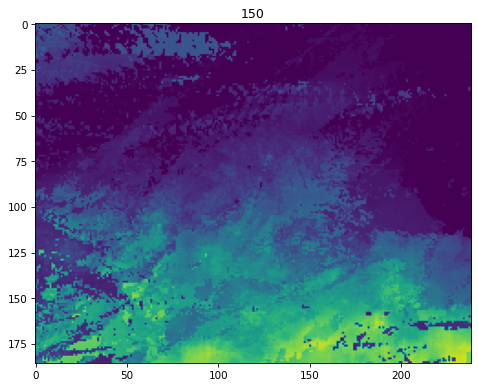

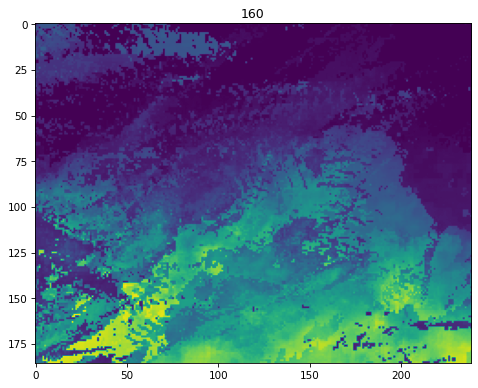

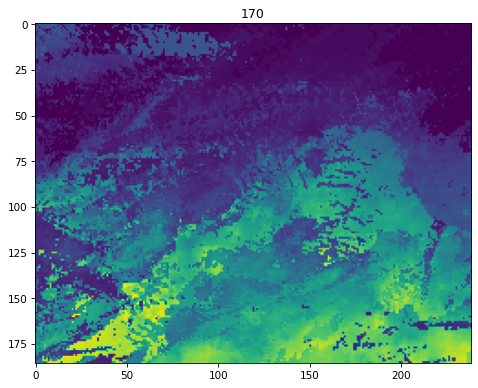

In [19]:
variable = "rdt"
for i in range(int(duration/10)):
    figure(figsize=(8, 6), dpi=75)
    plt.imshow(data[variable][:,:,int(i*10)], vmin=0, vmax=np.max(data[variable]))
    plt.title(i*10)
    plt.show()